# ChatGPT API ашиглан жиргээнд хэрхэн sentiment анализ хийх вэ?

Twitter API ашиглан тодорхой түлхүүр үгээр хайлт хийж тэрхүү датан дээр ChatGPT API ашиглан sentiment анализ хийж туршиж үзлээ. 
Twitter API нь үнэгүй байсан бол одоо үнэгүй хэрэглэгчидэд хязгаар тогтоож өгсөн учир нэг удаадаа 100 хүрэхгүй дата авах 
боломжтой. 
Харин ChatGPT API хувьд ийм төрлийн анализ хийхэд харьцангүй хямд. Гэхдээ зарим улс төрийн satire ойлгохгүй ганц нэг худлаа 
таамаглах тохиолдол гарч байна. Жишээ нь:
- Author: AltangerelAlza1 
- Tweet: @amarjargalmiji1 Нямбаатар ажилаа хиймээр байнаа.  
- Sentiment: positive

Графикийн доор ашигласан пайтон кодыг хавсаргав. 

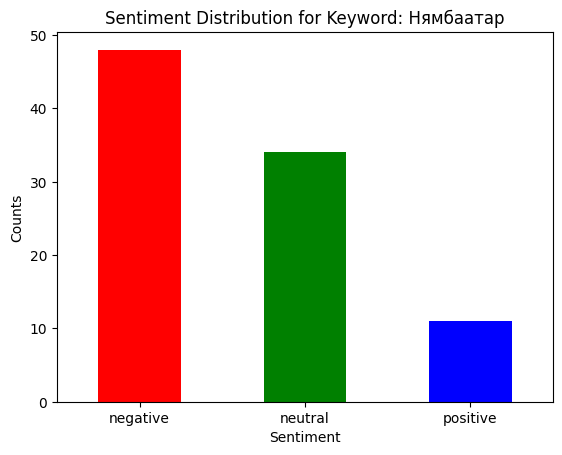

In [45]:
plot_sentiment_bar_chart(df, 'sentiment')

## Код болон жиргээ тус бүр дээр хэрхан таамаг хийснийг харна уу?

In [46]:
printInColor(df)


            Author: sh_buya 
            Tweet: Сүүлийн 34 жил Төр засгийн томчуудаас авхуулаад орон нутгийн дарганцаруудын ганц хийдэг ажил нь "гадны туршлага судлах" нэрийн дор ард түмний татварын мөнгөөр гадаадад зугаалах.
Нямбаатар гуай ганцаар биш бүр дефакто Жагайг бараа бологчоо болгож АНУ-д аялж зугаалж яваа бололтой! https://t.co/1Yr9gQ49su  
            Sentiment: negative
            

            Author: Hgl8WE 
            Tweet: Газрын наймаа хэмээх том зөрчилтэй МУ-ын ЕС Л.Оюун-эрдэнэ, Хууль зүйн сайд Энхбаяр, хотын дарга Нямбаатар тэмцэнэ гэнэ. 
Үе үеийн хотын дарга нар, газрын албаны дарга нар нүх сүв болгоныг зарж хөлжсөн нөхдүүдийг ил болгож хариуцлага тооцох хэрэгтэй. 
Ард түмэн харах л үлдлээ 🇲🇳 https://t.co/MOQdJZv94P  
            Sentiment: negative
            

            Author: Gerlee_smile 
            Tweet: Томчуудын автобусаа мэдэхгүй төөрөх ч дүүрч гэхэд одоо хүүхдүүд яаж дамжиж яаж хичээлдээ явнаа? Нямбаатар хаа явнаа? Ням гаригийн шөнө гэнэт шийдвэр

In [47]:
from requests_oauthlib import OAuth1Session
import json
import pandas as pd
import datetime
import sqlite3
import time
from sqlalchemy import create_engine
import openai

In [4]:
current_dir = os.getcwd()
chatgpt_cred = os.path.join(current_dir, "config.json")
log_file = os.path.join(current_dir, "script_log.txt")
cred_file = os.path.join(current_dir, "twitter_credentials.json")
db_path = os.path.join(current_dir, "tweets.sqlite")
output_file = os.path.join(current_dir, "new.csv")
daily = os.path.join(current_dir, "daily_tweets_from_ai.csv")
image_input_file = os.path.join(current_dir, "canva.png")
image_output_file = os.path.join(current_dir, "post.jpg")


engine = create_engine(f'sqlite:///{db_path}')
now = datetime.datetime.now()
now.strftime('%Y-%m-%d-%H-%M')


# Load the API key from a JSON file
with open(chatgpt_cred , 'r') as file:
    config = json.load(file)
    api_key = config['openai_api_key']

openai.api_key = str(api_key)

# Functions

In [30]:
def search_tweets_to_csv_with_media(key_word, output_file=output_file):
    # Load credentials
    with open(cred_file, 'r') as f:
        creds = json.load(f)

    consumer_key = creds['consumer_key']
    consumer_secret = creds['consumer_secret']
    access_token = creds['access_token']
    access_token_secret = creds['access_token_secret']

    # Create an OAuth1Session instance with your credentials
    oauth = OAuth1Session(
        consumer_key,
        client_secret=consumer_secret,
        resource_owner_key=access_token,
        resource_owner_secret=access_token_secret,
    )

    # The endpoint for searching tweets
    url = "https://api.twitter.com/2/tweets/search/recent"
    
    # Parameters for the request
    params = {
        "query": f"{key_word} -is:retweet",
        "tweet.fields": "attachments,created_at",
        "expansions": "attachments.media_keys,author_id",
        "user.fields": "username",  # Add this line
        "media.fields": "url",
        "max_results": 100
    }

    # Making the request to search tweets
    response = oauth.get(url, params=params)
    print(response.status_code)
    # Check if the request was successful
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(response.status_code, response.text)
        )

    # Process the response
    json_response = response.json()
    tweets = json_response.get('data', [])
    users = {u['id']: u for u in json_response.get('includes', {}).get('users', [])}
    media = {m['media_key']: m for m in json_response.get('includes', {}).get('media', [])}

    # Enhance each tweet with user and media information
    enhanced_tweets = []
    for tweet in tweets:
        # Get user info for the tweet
        user_info = users.get(tweet['author_id'], {})
        tweet['username'] = user_info.get('username', '')
        tweet['sentiment'] = ''

        # Get media info if available
        if 'attachments' in tweet and 'media_keys' in tweet['attachments']:
            media_keys = tweet['attachments']['media_keys']
            tweet_media = [media[key] for key in media_keys if key in media]
            tweet['media'] = tweet_media
        else:
            tweet['media'] = []

        # Append the enhanced tweet to the list
        enhanced_tweets.append(tweet)
    enhanced_tweets
    tweets_df = pd.DataFrame(enhanced_tweets)
    return tweets_df

# Sentiment Analysis

In [31]:
def get_completion(prompt, model="gpt-4-1106-preview"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0.9,
        frequency_penalty = 0.5,
        max_tokens = 200,
    )
    return response.choices[0].message["content"]

def get_sent_from_chatgpt(x):
    prompt = f'''
    read this mongolian tweet sentence and
    Send me one word. If it is positive, then "positive".
    If it is negative, then send me "negative"
    if It is neutral, then send me "neutral".
    Input tweet: {x}
    output must be one word. nothing else.
    '''
    completion = get_completion(prompt)
    return completion


In [32]:
keyword = "Нямбаатар"
df = search_tweets_to_csv_with_media(keyword)
print(df.shape[0])

200
100


In [33]:
df['sentiment'] = df.text.map(lambda x: get_sent_from_chatgpt(x))
df = df[['author_id', 'id', 'created_at', 'text','username', 'sentiment']]
df.to_sql('mongol', con=engine, if_exists='append', index=False)

100

In [34]:
sql_query = '''
WITH unique_text AS (
    SELECT DISTINCT text 
    FROM mongol
)
SELECT distinct *
FROM unique_text
JOIN mongol ON mongol.text = unique_text.text
where author_id != 1116204101098860544
'''



df= pd.read_sql_query(sql_query, engine)
# Assuming df is your DataFrame
end = df.shape[0]
print(f"Total tweets: {end}")
df

Total tweets: 103


,text,id,created_at,author_id,username,sentiment
0,@Uyanga_ts “Энэ дэлхийн ядарсан зүдэрсэн бүхни...,1751610805676585123,2024-01-28T14:18:54.000Z,1650779049659183104,khoridolsar,negative
1,@amarbayarm Нямбаатар дарга явдаг юм. байсан б...,1751584394492710942,2024-01-28T12:33:57.000Z,1483395256095809543,AmarkhuuD,neutral
2,@amarbayarm Нямбаатар дарга явдаг юм. байсан б...,1751584394492710942,2024-01-28T12:33:57.000Z,1483395256095809543,AmarkhuuD,positive
3,Нямбаатар автобусаан харамлаад байхаар нь ийм ...,1751583655498252472,2024-01-28T12:31:00.000Z,1519497884320014338,NanzaddorjDemb2,negative
4,"Ард түмэний сэтгэл хөдлөл , уур хилэн намдсан ...",1751546553301680317,2024-01-28T10:03:35.000Z,1738778844293943296,Saul_12S,negative
...,...,...,...,...,...,...
98,"Оюун-Эрдэнэ, Нямбаатар нар ойр тойрны хүмүүсдэ...",1750447311828787505,2024-01-25T09:15:35.000Z,63979770,hariad_uyanga,negative
99,Эээ бурхан минь тэр газын машины жолоочийг амь...,1750439099373334907,2024-01-25T08:42:57.000Z,1417548986,AEnkhtsetseg,negative
100,Яг хэдэн цэрэг үхэж байж Сайханбаяр сайдаас бу...,1750437360490422556,2024-01-25T08:36:02.000Z,413762966,a_tserenbat,negative
101,"Оюунэрдэнэ, Амарбаясгалан, Нямбаатар гурвыг ху...",1750423966295208437,2024-01-25T07:42:49.000Z,223495564,ariunkhishigG,neutral


In [42]:
sql_query = '''
WITH RankedTweets AS (
    SELECT
        author_id,
        id,
        text,
        created_at,
        username,
        sentiment,
        ROW_NUMBER() OVER (PARTITION BY author_id ORDER BY created_at) as rank
    FROM mongol
)
SELECT
        author_id,
        id,
        text,
        created_at,
        username,
        sentiment
FROM RankedTweets
WHERE rank = 1
'''

df= pd.read_sql_query(sql_query, engine)
# Assuming df is your DataFrame
end = df.shape[0]
print(f"Total tweets: {end}")
df

Total tweets: 93


,author_id,id,text,created_at,username,sentiment
0,1056867002,1750466580629360841,Сүүлийн 34 жил Төр засгийн томчуудаас авхуулаа...,2024-01-25T10:32:09.000Z,sh_buya,negative
1,1080742505967017984,1750784400240050527,Газрын наймаа хэмээх том зөрчилтэй МУ-ын ЕС Л....,2024-01-26T07:35:03.000Z,Hgl8WE,negative
2,1111224885110427648,1750750297759318511,Томчуудын автобусаа мэдэхгүй төөрөх ч дүүрч гэ...,2024-01-26T05:19:33.000Z,Gerlee_smile,negative
3,1116204101098860544,1750478590494539804,Х.Нямбаатар Хотын дарга тэгсэн мөртлөө иргэдэд...,2024-01-25T11:19:52.000Z,ShinebayarTny,negative
4,1151344579058130948,1751635238202273911,Циркийн барилгыг буулгахгүй ч хажууд нь сүр ба...,2024-01-28T15:55:59.000Z,ochbayarg,negative
...,...,...,...,...,...,...
88,886918789811458050,1750901616470090106,"@Chuluunbat201 Эрхэмлэж, хайрлаж, нандигнах мэ...",2024-01-26T15:20:50.000Z,ganganorov,negative
89,90815409,1750725531241431211,"@z_erdenesaikhan Оюун-Эрдэнэ, Нямбаатар, Амарс...",2024-01-26T03:41:08.000Z,iimgai,neutral
90,91315901,1750712201080352821,@Undram Нямбаатар Оюулзгана,2024-01-26T02:48:10.000Z,Tsa_tsaa,neutral
91,945945792,1750485537612525802,"Оюун-Эрдэнэ, Нямбаатар нарыг одоо огцруулах гэ...",2024-01-25T11:47:29.000Z,tayar_bayar,negative


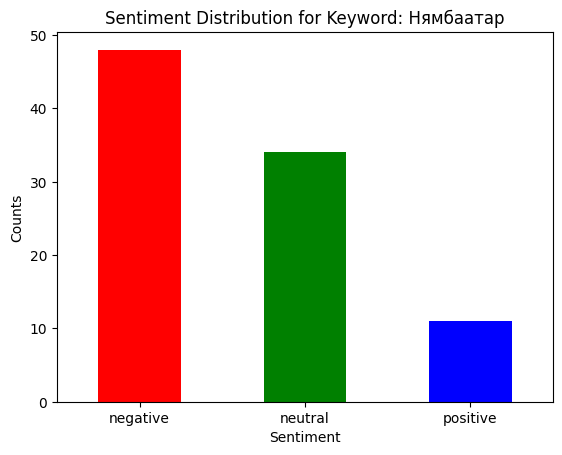

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sentiment_bar_chart(df, sentiment_column):
    """
    Plots a bar chart of sentiment distribution.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the sentiment data.
    sentiment_column (str): The name of the column in df that contains sentiment values.
    """
    # Count the occurrences of each sentiment
    sentiment_counts = df[sentiment_column].value_counts()

    # Plotting
    sentiment_counts.plot(kind='bar', color=['red', 'green', 'blue'])
    plt.title(f'Sentiment Distribution for Keyword: {keyword}')
    plt.xlabel('Sentiment')
    plt.ylabel('Counts')
    plt.xticks(rotation=0)  # Rotate x-labels for better readability
    plt.show()

# Example usage
# Assuming 'your_dataframe' is your DataFrame and 'sentiment' is the column name
plot_sentiment_bar_chart(df, 'sentiment')


In [44]:
def printInColor(df):
    # ANSI escape codes for some colors
        RED = '\033[31m'   # Red Text
        GREEN = '\033[32m' # Green Text
        BLUE = '\033[34m'  # Blue Text
        RESET = '\033[0m'  # Reset to default color

        for i in range(0, df.shape[0]):
            print(f'''
            {GREEN}Author{RESET}: {df.username[i]} 
            {BLUE}Tweet{RESET}: {df.text[i]}  
            {RED}Sentiment{RESET}: {df.sentiment[i]}
            ''')